In [1]:
import os
import glob
import h5py
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.metrics import roc_curve, precision_recall_curve, f1_score, roc_auc_score, average_precision_score
from torch import sigmoid
from tqdm.notebook import tqdm

from rt_bene.blink_estimation_models_pytorch import BlinkEstimationModelResnet18, BlinkEstimationModelResnet50, \
    BlinkEstimationModelVGG19, BlinkEstimationModelDenseNet121, BlinkEstimationModelVGG16
from rt_bene_model_training.pytorch.rtbene_dataset import RTBENEH5Dataset

In [3]:
models = {
    "resnet18": BlinkEstimationModelResnet18,
    "resnet50": BlinkEstimationModelResnet50,
    "vgg16": BlinkEstimationModelVGG16,
    "vgg19": BlinkEstimationModelVGG19,
    "densenet121": BlinkEstimationModelDenseNet121
}

modes = ["ensemble", "single"]

hdf5_file = os.path.abspath(os.path.expanduser("~/datasets/rtbene_dataset.hdf5"))
model_base = "vgg16"
model_net_dir = os.path.abspath("../rt_gene/rt_gbene_model_training/pytorch/model_nets")
mode = "ensemble"
model_files = glob.glob(os.path.join(model_net_dir, "*.model"))

assert model_base in models.keys(), "_model_base requested is not supported"
assert mode in modes, "prediction mode must be either 'single' or 'ensemble'"
assert len(model_files) > 0, "No .model files found in directory"

valid_subjects = [0, 11, 15, 16]
# create a master list of predictions and labels
model_inferences = {}

In [ ]:
if mode == "single":
    for model_file in tqdm(model_files, desc="Models..", position=1):
        labels = []
        predictions = []
        model_nn = models.get(model_base)()
        model_nn.load_state_dict(torch.load(model_file))
        model_nn.cuda()
        model_nn.eval()
        for subject in tqdm(valid_subjects, desc="Subjects...", position=2):
            data_validate = RTBENEH5Dataset(h5_file=h5py.File(hdf5_file, mode="r"), subject_list=[subject], loader_desc=subject)
            for index in tqdm(range(0, len(data_validate)), desc="Images...", position=3):
                _left, _right, _label = data_validate[index]
                _predicted_blink = sigmoid(model_nn(_left.unsqueeze(0).float().cuda(), _right.unsqueeze(0).float().cuda()))
                labels.extend(_label)
                predictions.append(float(_predicted_blink.detach().cpu()))

        model_inferences[model_file] = {"labels": labels, "predictions": predictions}

In [ ]:
if mode == "ensemble":
    model_ensemble = []
    for model_file in tqdm(model_files, desc="Loading Models..", position=1):
        model_nn = models.get(model_base)()
        model_nn.load_state_dict(torch.load(model_file))
        model_nn.cuda()
        model_nn.eval()
        model_ensemble.append(model_nn)

    labels = []
    predictions = []
    for subject in tqdm(valid_subjects, desc="Subjects...", position=2):
            data_validate = RTBENEH5Dataset(h5_file=h5py.File(hdf5_file, mode="r"), subject_list=[subject], loader_desc=subject)
            for index in tqdm(range(0, len(data_validate)), desc="Images...", position=3):
                _left, _right, _label = data_validate[index]
                _predicted_blinks = [sigmoid(m(_left.unsqueeze(0).float().cuda(), _right.unsqueeze(0).float().cuda())) for m in model_ensemble]
                _predicted_blinks = torch.stack(_predicted_blinks, dim=1)
                _predicted_blink = torch.mean(_predicted_blinks, dim=1).detach().cpu()
                labels.extend(_label)
                predictions.append(float(_predicted_blink))

    model_inferences['ensemble'] = {"labels": labels, "predictions": predictions}

Optimal Threshold from ROC 0.75, optimal threshold from PRC 0.99


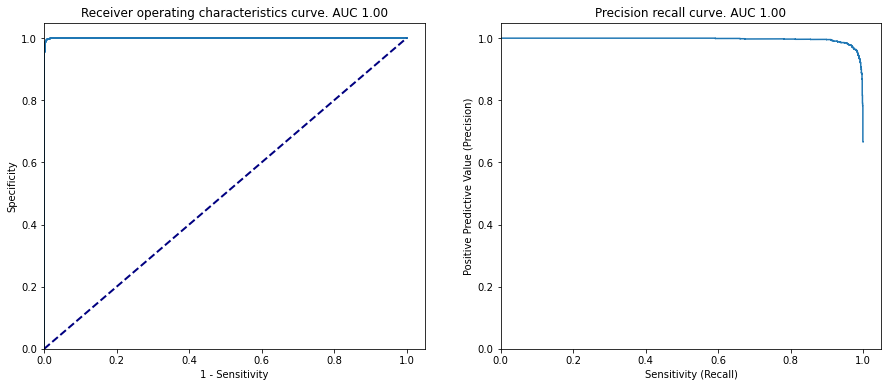

In [4]:
fig, (roc_fig, prc_fig) = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
aurocs = []
auprcs = []
for model_name, inferences in model_inferences.items():
    labels = inferences['labels']
    predictions = inferences['predictions']
    fpr, tpr, ft_thresholds = roc_curve(y_true=labels, y_score=predictions)
    positive_predictive_value, sensitivity, pr_thresholds = precision_recall_curve(labels, predictions)
    optimal_roc_idx = np.argmax(tpr - fpr)
    optimal_roc_threshold = ft_thresholds[optimal_roc_idx]
    optimal_prc_idx = np.argmax(sensitivity + positive_predictive_value)
    optimal_prc_threshold = pr_thresholds[optimal_prc_idx]
    auroc = roc_auc_score(y_true=labels, y_score=predictions)
    auprc = average_precision_score(y_true=labels, y_score=predictions)
    aurocs.append(auroc)
    auprcs.append(auprc)

    prc_fig.step(sensitivity, positive_predictive_value, where='post')
    roc_fig.plot(fpr, tpr, lw=2)
    print("Optimal Threshold from ROC {:.2f}, optimal threshold from PRC {:.2f}".format(optimal_roc_threshold, optimal_prc_threshold))


roc_fig.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
roc_fig.set_xlim([0.0, 1.05])
roc_fig.set_ylim([0.0, 1.05])
roc_fig.set_xlabel('1 - Sensitivity')
roc_fig.set_ylabel('Specificity')
roc_fig.set_title('Receiver operating characteristics curve. AUC {:.2f}'.format(np.array(aurocs).mean()))

prc_fig.set_xlabel('Sensitivity (Recall)')
prc_fig.set_ylabel('Positive Predictive Value (Precision)')
prc_fig.set_ylim([0.0, 1.05])
prc_fig.set_xlim([0.0, 1.05])

prc_fig.set_title("Precision recall curve. AUC {:.2f}".format(np.array(auprcs).mean()))
plt.savefig(os.path.abspath(os.path.expanduser(f"~/catkin_ws/src/rt_gene/assets/rtbene_pytorch_resnet18_{mode}.png")))
plt.show()

Calculating F-Scores:   0%|          | 0/1000 [00:00<?, ?it/s]

Optimal Threshold from F1-Score Thresholding 0.99


Text(0.5, 1.0, 'Optimal Threshold: 0.99')

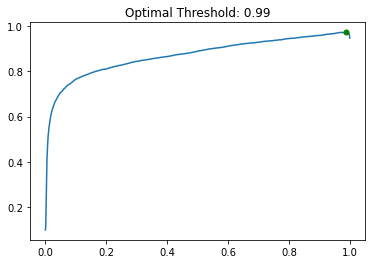

In [5]:
fig = plt.figure()
f1_thresholds = []
for model_name, inferences in model_inferences.items():
    labels = inferences['labels']
    predictions = inferences['predictions']
    thresholds = np.arange(0.0, 1.0, 0.001)
    f1scores = np.zeros(shape=(len(thresholds)))
    # Sweep across the thresholds and calculate the f1-score for those predictions.
    # The idea here is that the threshold with the highest f1-score is ideal
    for index, elem in tqdm(enumerate(thresholds), total=len(thresholds), desc="Calculating F-Scores"):
        # Corrected probabilities
        y_pred_prob = (np.array(predictions) > elem).astype('int')
        # Calculate the f-score
        f1scores[index] = f1_score(np.array(labels), y_pred_prob)

    # Find the optimal threshold
    f1score_argmax_index = np.argmax(f1scores)
    optimal_f1score_threshold = thresholds[f1score_argmax_index]
    f1score_at_optimal_threshold = f1scores[f1score_argmax_index]
    plt.plot(thresholds, f1scores)
    plt.plot(optimal_f1score_threshold, f1score_at_optimal_threshold, color="g", marker="o", markersize=5)
    print(f'Optimal Threshold from F1-Score Thresholding {optimal_f1score_threshold:.2f}')
    f1_thresholds.append(optimal_f1score_threshold)
plt.title(f"Optimal Threshold: {np.array(f1_thresholds).mean():.2f}")
